<div class="alert alert-info">
    <h1 align="center"> Persian Image Captioning</h1>
    <h3 align="center">Deep Learning in Python (HamYad Lab.)</h3>
    <h5 align="center"><a href="http://www.snrazavi.ir">Seyed Naser RAZAVI</a></h5>
</div>

## Image Captioning

- Input: image.
- Output: A sequence of words in a natural language, which hopefully describes the contents of the input Image.

## Libraries

In [107]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from IPython.display import display

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence

import torchvision.transforms as transforms
import torchvision.models as models

#from utils import *
from build_vocab import build_vocab
from data_loader import get_loader

# setup
use_gpu = torch.cuda.is_available()

### Helper functions

In [6]:
def load_cnn_model(model_name, pretrained=True):
    "Load and return a convolutional neural network."
    assert model_name in ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152']
    return models.__dict__[model_name](pretrained)


def load_image(image_path, transform=None):
    "Load an image and perform given transformations."
    image = Image.open(image_path)    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    return image

## Data

- [Microsoft COCO Dataset](http://cocodataset.org/#captions-2015)
- More than 80k training images and 40k validation images.
- At leat 5 captions for every image.

### Load Images and Captions Data

In [9]:
def load_json(filename='data/fa_images_captions_train.json'):
    with open(filename, 'r') as f:
        annotations = json.load(f)
    return annotations

dataset = load_json('/home/ies/Desktop/ML_Practice/Persian_Image_Captioning/cocoapi/annotations/captions_val2014.json')

In [42]:
print(dataset.keys())

dict_keys(['info', 'images', 'licenses', 'annotations'])


In [54]:
print(dataset['images'][0])

{'license': 3, 'file_name': 'COCO_val2014_000000391895.jpg', 'coco_url': 'http://images.cocodataset.org/val2014/COCO_val2014_000000391895.jpg', 'height': 360, 'width': 640, 'date_captured': '2013-11-14 11:18:45', 'flickr_url': 'http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg', 'id': 391895}


In [51]:
print(dataset['annotations'][0])

{'image_id': 203564, 'id': 37, 'caption': 'A bicycle replica with a clock as the front wheel.'}


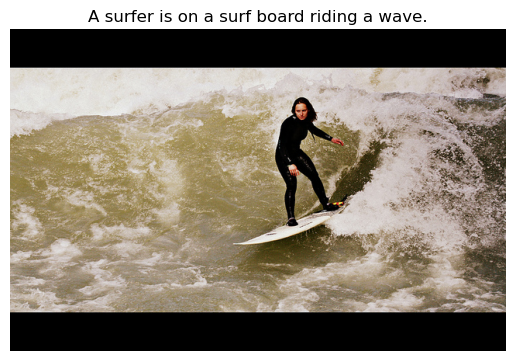

In [57]:

#show_random_image_with_caption(dataset)
def show_image(image_file, caption):
    img = plt.imread(image_file)
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, size='large')

# pick a random image and obtain the corresponding caption and filename
N = len(dataset['annotations'])
idx = np.random.choice(range(N))

item = dataset['annotations'][idx]
caption = item['caption']

img_id = item['image_id']

# Find the image file name corresponding to the img_id
filename = None
for image in dataset['images']:
    if image['id'] == img_id:
        filename = image['file_name']
        break

if filename is None:
    print(f"Image with id {img_id} not found.")
else:
    image_file = os.path.join('/home/ies/Desktop/ML_Practice/Persian_Image_Captioning/cocoapi/val2014/', filename)
    show_image(image_file, caption)

### Building vocabulary

In [78]:
DATA_DIR = 'data'
captions_filename = f'{DATA_DIR}/captions.txt'

N = len(dataset['annotations'])
for id in range(N):
    item = dataset['annotations'][id]
    caption = item['caption']
    with open(captions_filename, 'a') as file:
    # Append content to the file
        file.write(caption + '\n')

In [80]:
DATA_DIR = 'data'
#captions_filename = f'{DATA_DIR}/fa_captions.txt'
vocab_filename = f'{DATA_DIR}/vocab.pkl'

if os.path.exists(vocab_filename):
    vocab = pickle.load(open(vocab_filename, 'rb'))
else:
    vocab = build_vocab(captions_filename, min_count=0)
    pickle.dump(vocab, open(vocab_filename, 'wb'))

Vocab:   0%|          | 0/203451 [00:00<?, ?it/s]

In [81]:
print(len(vocab))

22103


In [82]:
for i in range(20):
    print("%s --> %d" %(vocab.idx2word[i], i))

<PAD> --> 0
<BOS> --> 1
<EOS> --> 2
<UNK> --> 3
a --> 4
. --> 5
A --> 6
on --> 7
of --> 8
in --> 9
the --> 10
with --> 11
and --> 12
is --> 13
man --> 14
to --> 15
sitting --> 16
, --> 17
at --> 18
standing --> 19


### Data loader

In [83]:
DATASET_DIR = '/home/ies/Desktop/ML_Practice/Persian_Image_Captioning/cocoapi/'
images_dir = f'{DATASET_DIR}/val2014'
captions_json = f'{DATASET_DIR}/annotations/captions_val2014.json'
image_size = 256
crop_size  = 224
batch_size = 16


transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomCrop(crop_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

In [88]:
data_loader = get_loader(images_dir, captions_json, vocab, 
                         transform, batch_size, 
                         shuffle=True, num_workers=0)

loading annotations into memory...
Done (t=0.28s)
creating index...
index created!


In [110]:
# Assuming data_loader is your PyTorch DataLoader
imgs, caps, lengths = next(iter(data_loader))

# Extracting the first caption and removing special tokens
first_caption_ids = caps[0][1:-1]

# Print word IDs
print("Word IDs:", " ".join([str(id.item()) for id in first_caption_ids]))

# Print corresponding words, handling missing indices
print("Words:", " ".join([vocab.idx2word.get(id.item(), '<unk>') for id in first_caption_ids]))



Word IDs: 6 14 13 2938 11 46 746 9 10 138 90 4 80 11 10 176 9 10 156 5
Words: A man is parallel with his legs in the air over a beach with the ocean in the background .


In [95]:
imgs.size()

torch.Size([16, 3, 224, 224])

In [96]:
print(caps.size())

torch.Size([16, 18])


## Model

<img src="imgs/enc-dec-arch.png" width="90%"/>

### Encoder (CNN)

In [118]:
class EncoderCNN(nn.Module):
    def __init__(self, model_name, embed_size):
        super(EncoderCNN, self).__init__()
        
        # load cnn and remove last layer
        cnn = load_cnn_model(model_name)
        modules = list(cnn.children())[:-1]  # remove last layer
        
        self.cnn = nn.Sequential(*modules)
        self.linear = nn.Linear(cnn.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        self.init_weights()
                
    def init_weights(self):
        self.linear.weight.data.normal_(0, 0.02)
        self.linear.bias.data.fill_(0)
        
    def forward(self, x):
        x = self.cnn(x)  # extract features from input image
        x = Variable(x.data)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        x = self.bn(x)
        return x
    
    def fine_tune(self, requires_grad=True):
        for param in self.cnn.layer4.parameters():
            param.requires_grad = requires_grad

### Decoder (LSTM)

In [119]:
class DecoderLSTM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout, tie_weights):
        super(DecoderLSTM, self).__init__()
        
        if tie_weights:
            embed_size = hidden_size
            
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=0.35)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(p=dropout)
        
        if tie_weights:
            # share weights between embedding and classification layer
            self.fc.weight = self.embedding.weight
            
        self.init_weights()
        
    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        
    def forward(self, features, captions, lengths):
        x = self.embedding(captions)
        x = torch.cat([features.unsqueeze(1), x], dim=1)
        x = self.dropout(x)
        x = pack_padded_sequence(x, lengths, batch_first=True)
        x, _ = self.lstm(x)
        x = self.dropout(x[0])
        x = self.fc(x)
        return x
    
    def sample(self, features, states=None):
        """Samples captions for given image features (Greedy search)."""
        sampled_ids = []
        inputs = features.unsqueeze(1)

        for i in range(20):                                      # maximum sampling length
            hiddens, states = self.lstm(inputs, states)          # (batch_size, 1, hidden_size), 
            outputs = self.fc(hiddens.squeeze(1))                # (batch_size, vocab_size)
            token_id = outputs.max(1)[1]
            sampled_ids += [token_id]
            inputs = self.embedding(token_id)
            inputs = inputs.unsqueeze(1)                         # (batch_size, 1, embed_size)
        sampled_ids = torch.cat(sampled_ids, 0)                  # (batch_size, 20)
        return sampled_ids.squeeze()

### Encoder-Decoder

In [120]:
class EncoderDecoder(nn.Module):
    
    def __init__(self, cnn_name, vocab_size, embed_size, hidden_size, num_layers, dropout, tie_weights):
        super(EncoderDecoder, self).__init__()
        
        if tie_weights:
            embed_size = hidden_size
            
        self.encoder = EncoderCNN(cnn_name, embed_size)
        self.decoder = DecoderLSTM(vocab_size, embed_size, hidden_size, num_layers, dropout, tie_weights)
        
        # create output folder to save weights
        self.save_path = f'{cnn_name}-{embed_size}-{hidden_size}-{num_layers}'
        if not os.path.exists(self.save_path):
            os.mkdir(self.save_path)
    
    def forward(self, images, captions, lengths):
        features = self.encoder(images)
        outputs = self.decoder(features, captions, lengths)
        return outputs
    
    def save(self, epoch, loss):
        torch.save({'encoder': self.encoder.state_dict(), 
                    'decoder': self.decoder.state_dict()}, f'{self.save_path}/{epoch}-{loss:.2f}.pth')
    
    def load(self, epoch):
        model_path = glob(f'{self.save_path}/{epoch}-*.pth')[-1]
        try:
            d = torch.load(model_path)
            self.encoder.load_state_dict(d['encoder'])
            self.decoder.load_state_dict(d['decoder'])
        except:
            print('Invalid epoch number <{}>, the model does not exist!'.format(epoch))

### Parameters

In [121]:
from torch.autograd import Variable
def to_var(x, volatile=False):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, volatile=volatile)

# model hyper-parameters
cnn_name = 'resnet50'
embed_size  = 512
hidden_size = 512
num_layers  = 2
tie_weights = True

# training hyper-parameters
start_epoch = 0
num_epochs  = 20
learning_rate = 0.001

## Training

In [122]:
def train_epoch(model, train_dl, criterion, optimizer, scheduler, epoch, last_epoch):
    model.encoder.train()
    model.decoder.train()
    scheduler.step()
    
    total_steps = len(train_dl)
    epoch_loss = 0.0
    
    for i, (images, captions, lengths) in enumerate(train_dl):
        images, captions = to_var(images), to_var(captions)
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
        
        # forward step
        outputs = model(images, captions, lengths)
        loss = criterion(outputs, targets)
        epoch_loss = (epoch_loss * i + loss.item()) / (i + 1)
        
        # backward step
        model.encoder.zero_grad()
        model.decoder.zero_grad()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.decoder.parameters(), 5.0)
        optimizer.step()
        
        # report log info
        sys.stdout.flush()
        sys.stdout.write('\rEpoch [%2d/%2d], Step [%3d/%3d], Loss = %.4f, Perplexity = %.4f    '
                         % (epoch+1, last_epoch, i+1, total_steps, epoch_loss, np.exp(epoch_loss)))
    print()

    return epoch_loss


def train(model, train_dl, criterion, optimizer, scheduler, start_epoch=0, num_epochs=10):
    last_epoch = start_epoch + num_epochs
        
    for epoch in range(start_epoch, last_epoch):                
        # train step
        trn_loss = train_epoch(model, data_loader, criterion, optimizer, scheduler, epoch, last_epoch)
        
        # save model
        model.save(epoch, trn_loss)

### Encoder-Decoder

In [123]:
model = EncoderDecoder(cnn_name, len(vocab), embed_size, hidden_size, num_layers, 0.3, tie_weights)
if use_gpu:
    model = model.cuda()

### Loss and optimizer

In [124]:
# loss function
criterion = nn.CrossEntropyLoss()
if use_gpu:
    criterion = criterion.cuda()
    
# list of parameters which will be updated
params = list(model.decoder.parameters())
params += list(model.encoder.linear.parameters()) 
params += list(model.encoder.bn.parameters())

# optimizer
optimizer = torch.optim.RMSprop(params, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.97)



### Training

In [125]:
train(model, data_loader, criterion, optimizer, scheduler, start_epoch, num_epochs)

/home/ies/anaconda3/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/tmp/ipykernel_24586/4091140947.py:23: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.decoder.parameters(), 5.0)


Epoch [ 1/20], Step [ 21/12666], Loss = 6.7095, Perplexity = 820.1620       

KeyboardInterrupt: 

## Sampling: generate captions

In [25]:
from PIL import Image

val_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

In [26]:
def generate_caption(model, img_filenames):
    model.encoder.eval()
    model.decoder.eval()
    
    captions = []
    
    for img_filename in img_filenames:

        # prepare test image
        image = load_image(img_filename, val_transform)
        image_tensor = to_var(image, volatile=True)

        # Generate features from image
        feature = model.encoder(image_tensor)

        # Generate caption from image
        sampled_ids = model.decoder.sample(feature)
        sampled_ids = sampled_ids.cpu().data.numpy()

        # decode word ids to words
        sampled_caption = []
        for word_id in sampled_ids:
            word = vocab.idx2word[word_id]
            if word == '<EOS>': break
            sampled_caption.append(word)

        caption = " ".join(sampled_caption[1:])
        captions.append((img_filename, caption))
    
    return captions

In [27]:
img_filenames = glob('data/images/*.jpg')[:10]
captions = generate_caption(model, img_filenames)

for img, caption in captions:
    display(show_persian_image_and_caption(caption, img))

In [28]:
img_filenames = glob('./data/im2txt/*.jpg')[:10]
captions = generate_caption(model, img_filenames)

for img, caption in captions:
    display(show_persian_image_and_caption(caption, img))

## Possible Improvements

- Using a larger dataset
- Using pre-trained word vectors
- Using a BiLSTM
- Increasing depth of LSTM
- Using Attention mechanism
- Using Beam Search instead of Greedy Search
- Fine Tuning last layers of CNN.